In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: pho
"""
import sys
from threading import Thread
import time # for time.sleep
from ipygany import PolyMesh, Scene, IsoColor, WarpByScalar
import pyvista as pv
import pyvistaqt as pvqt
import colorcet as cc # Colormaps:
import numpy as np
import h5py
import hdf5storage # conda install hdf5storage
from pathlib import Path
import bqplot.scales
import seaborn as sns
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
# import mplcursors
import math # For color map generation
from matplotlib.colors import ListedColormap
from matplotlib.cm import hsv

import ipywidgets as widgets
# from PyQt5 import QtWidgets, uic
from pyvistaqt import QtInteractor, MainWindow
# from pyqt6 import QApplication
from IPython.external.qt_for_kernel import QtGui
from PyQt5.QtWidgets import QApplication

In [2]:
# import PhoPositionalData as pdp
# from PhoPositionalData import load_exported, process_data
from PhoPositionalData.load_exported import *
# from PhoPositionalData.process_data import process_positionalAnalysis_data, gen_2d_histrogram, get_heatmap_color_vectors, process_chunk_equal_poritions_data, extract_spike_timeseries
from PhoPositionalData.process_data import *
from PhoPositionalData.plot_data import *
from PhoPositionalData.plotting.animations import * # make_mp4_from_plotter, apply_close_overhead_zoomed_camera_view
from PhoPositionalData.import_data import * # build_spike_positions_list, build_cellID_reverse_lookup_map
from PhoPositionalData.analysis.interactive_placeCell_config import InteractivePlaceCellConfig, VideoOutputModeConfig, PlottingConfig  # VideoOutputModeConfig, InteractivePlaceCellConfigs

In [3]:
# NeuroPy (Diba Lab Python Repo) Loading
try:
    from neuropy import core
except ImportError:
    sys.path.append(r'C:\Users\Pho\repos\NeuroPy') # Windows
    # sys.path.append('/home/pho/repo/BapunAnalysis2021/NeuroPy') # Linux
    # sys.path.append(r'/Users/pho/repo/Python Projects/NeuroPy') # MacOS
    print('neuropy module not found, adding directory to sys.path. \n >> Updated sys.path.')
    from neuropy import core
from neuropy.core.dataSession import DataSession, processDataSession

# basedir = '/media/share/data/Bapun/Day5TwoNovel' # Linux
basedir = 'R:\data\Bapun\Day5TwoNovel' # Windows
# basedir = '/Volumes/iNeo/Data/Bapun/Day5TwoNovel' # MacOS
sess = core.processDataSession(basedir)

neuropy module not found, adding directory to sys.path. 
 >> Updated sys.path.
Issue with pickled POSIX_PATH on windows for path R:\data\Bapun\Day5TwoNovel\RatS-Day5TwoNovel-2020-12-04_07-55-09.probegroup.npy, falling back to non-pickled version...
linearized position loaded from file.
Loading success: .ripple.npy.
Loading success: .mua.npy.
Loading success: .pbe.npy.


In [4]:
## NOTE: The only place that I need to be careful with indexing is with sess.position properties, as these appear to be represented in terms of the number of 60Hz samples instead of in seconds like the Neurons and other classes.
active_epoch_name = 'maze1'
# active_epoch_name = 'maze2'
# active_subplots_shape = (1,1) # Single subplot
active_subplots_shape = '1|2' # 1 subplot on left, two on right
active_config = InteractivePlaceCellConfig(active_epoch_name,
                    VideoOutputModeConfig(active_frame_range=np.arange(15200.0, 18000.0), video_output_parent_dir=Path('output', active_epoch_name), active_is_video_output_mode=False),
                    PlottingConfig(output_subplots_shape=active_subplots_shape)) # '3|1
active_epoch_times = sess.epochs[active_config.active_epochs] 
# active_epoch_times = sess.epochs['maze2'] 
# active_epoch_times = sess.epochs['maze1']  # array([11070, 13970], dtype=int64)
print('Constraining to epoch with times (start: {}, end: {})'.format(active_epoch_times[0], active_epoch_times[1]))

active_epoch_session_Neurons = sess.neurons.get_neuron_type('pyr').time_slice(active_epoch_times[0], active_epoch_times[1]) # Filter by pyramidal cells only, returns a core.Neurons object with its spiketrains filtered for the provided start/end times
active_epoch_position_times_index_mask = sess.position.time_slice_indicies(active_epoch_times[0], active_epoch_times[1]) # a Boolean selection mask
active_epoch_position_times = sess.position.time[active_epoch_position_times_index_mask] # The actual times
active_epoch_relative_position_times = active_epoch_position_times - active_epoch_position_times[0] # Subtract off the first index, so that it becomes zero
active_epoch_pos = sess.position.time_slice(active_epoch_times[0], active_epoch_times[1]) # active_epoch_pos's .time and start/end are all valid
# have active_epoch_position_times: the actual times each position sample occured in seconds, active_epoch_relative_position_times: the same as active_epoch_position_times but starting at zero. Finally, have a complete active_epoch_pos object

## Compute Placefields if needed:
from neuropy.analyses import Pf1D, PF2d, Pf2D_new
should_force_recompute_placefields = True

try: active_epoch_placefields
except NameError: active_epoch_placefields = None # Checks variable active_epoch_placefields's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
if ((active_epoch_placefields is None) or should_force_recompute_placefields):
    print('Recomputing active_epoch_placefields...')
    active_epoch_placefields1D = Pf1D(neurons=active_epoch_session_Neurons, position=active_epoch_pos.linear_pos_obj, speed_thresh=4, grid_bin=7)
    # active_epoch_placefields = active_epoch_placefields1D
    print('done.')
else:
    print('active_epoch_placefields already exists, reusing it')
    
    
active_epoch_placefields2D_obj = Pf2D_new(neurons=active_epoch_session_Neurons, position=active_epoch_pos, speed_thresh=4, grid_bin=7)    
# active_epoch_placefields2D_old = PF2d(active_epoch_times, active_epoch_session_Neurons.spiketrains, active_epoch_session_Neurons.neuron_ids, active_epoch_pos.x, active_epoch_pos.y, active_epoch_pos.time, trackingRate=active_epoch_pos.sampling_rate, 
                                  # gridbin=7, speed_thresh=4, frate_thresh=1, smooth=2)
# active_epoch_placefields2D_old.plotMap()

active_epoch_placefields = active_epoch_placefields2D_obj

# Get the cell IDs that have a good place field mapping:
good_placefield_neuronIDs = np.array(active_epoch_placefields.ratemap.neuron_ids) # in order of ascending ID
good_placefield_neuronIDs

Constraining to epoch with times (start: 11070, end: 13970)
Recomputing active_epoch_placefields...
done.


array([  1,   3,  10,  11,  13,  14,  28,  34,  37,  38,  39,  41,  42,
        43,  44,  47,  48,  53,  54,  55,  56,  57,  58,  61,  63,  64,
        65,  68,  70,  75,  77,  80,  87,  91,  93,  95, 107], dtype=int64)

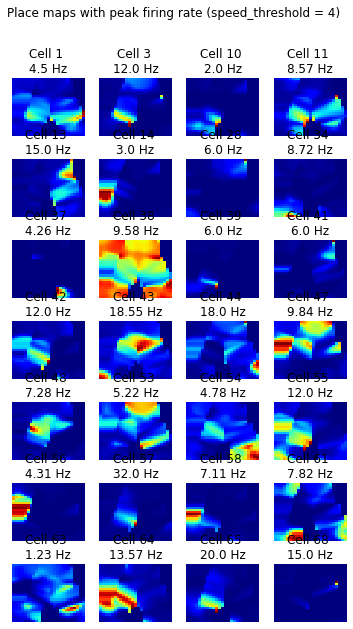

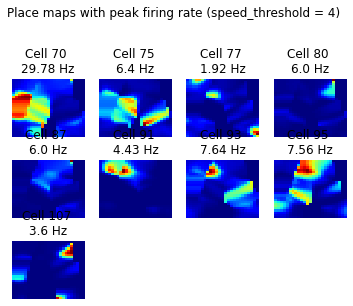

In [6]:
# normalize_xbin=False,
# normalize_ybin=False,
# ax=None,
# pad=2,
# normalize_tuning_curve=False,
# sortby=None,
# cmap="tab20b",

active_epoch_placefields2D_obj.plotMap()

from neuropy.utils import mathutil
curr_tuning_curves = mathutil.min_max_scaler(active_epoch_placefields.ratemap.tuning_curves) # 37x25x27 ndarray
sort_ind = np.argsort(np.argmax(curr_tuning_curves, axis=1))
# ind = np.unravel_index(np.argsort(curr_tuning_curves, axis=None), curr_tuning_curves.shape)
# sort_ind


Constraining to epoch with times (start: 11070, end: 13970)
Recomputing active_epoch_placefields...
done.


AttributeError: 'Pf2D_new' object has no attribute 'plot_ratemaps'

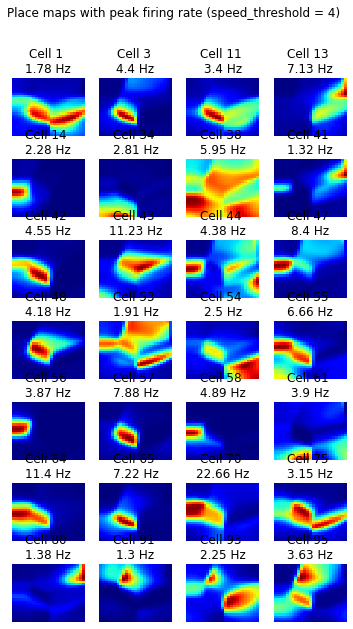

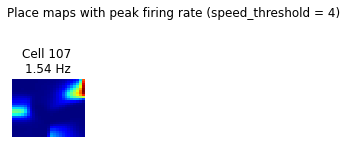

In [ ]:
pf_ax, pf_sort_ind, pf_colors = active_epoch_placefields.plot_ratemaps()
pf_sort_ind = np.array([int(pf_sort_ind[i]) for i in np.arange(len(pf_sort_ind))]) # convert to integer scalar array
pf_sorted_good_placefield_neuronIDs = good_placefield_neuronIDs[pf_sort_ind]
reverse_color_sort_indices = np.argsort(pf_sort_ind)
pf_colors = pf_colors[:, reverse_color_sort_indices] # pf_colors shape is still (4, 31)
active_epoch_session_Neurons = active_epoch_session_Neurons.get_by_id(good_placefield_neuronIDs) # Filter by good placefields only





# Unpacking final values into separate variables:
# Spike variables:
num_cells = active_epoch_session_Neurons.n_neurons
spike_list = active_epoch_session_Neurons.spiketrains
cell_ids = active_epoch_session_Neurons.neuron_ids
flattened_spikes = active_epoch_session_Neurons.get_flattened_spikes() # get_flattened_spikes(..) returns a FlattenedSpiketrains object
# Position variables: t, x, y
t = active_epoch_pos.time
x = active_epoch_pos.x
y = active_epoch_pos.y
linear_pos = active_epoch_pos.linear_pos
# speeds = active_epoch_pos.speed # note this has 1 less element than active_epoch_pos.x
# Determine the x and y positions each spike occured for each cell
spike_positions_list = build_spike_positions_list(spike_list, t, x, y)
reverse_cellID_idx_lookup_map = build_cellID_reverse_lookup_map(cell_ids)
print('num_cells: {}'.format(num_cells))
print('cell_ids: {}'.format(cell_ids)) # cell_ids is now a regular python list with 57 elements

active_cells_colormap = pf_colors.T # Make the colormap from the listed colors
active_cells_listed_colormap = ListedColormap(active_cells_colormap)

In [24]:
# Gets the flattened spikes, sorted in ascending timestamp for all cells.
num_flattened_spikes = np.size(flattened_spikes.flattened_spike_times)
print('num_flattened_spikes: {}'.format(num_flattened_spikes))
# Build the Active UnitIDs
flattened_spike_active_unitIdentities = np.array([int(reverse_cellID_idx_lookup_map[original_cellID]) for original_cellID in flattened_spikes.flattened_spike_identities]) # since flattened_spikes.flattened_spike_identities is already sorted, don't double sort
## Build the flattened spike positions list
flattened_spike_positions_list = np.concatenate(tuple(spike_positions_list), axis=1) # needs tuple(...) to conver the list into a tuple, which is the format it expects
flattened_spike_positions_list = flattened_spike_positions_list[:, flattened_spikes.flattened_sort_indicies] # ensure the positions are ordered the same as the other flattened items so they line up
print('flattened_spike_positions_list: {}'.format(np.shape(flattened_spike_positions_list)))

num_flattened_spikes: 99593
flattened_spike_positions_list: (2, 99593)


In [25]:
# have active_epoch_position_times: the actual times each position sample occured in seconds, active_epoch_relative_position_times: the same as active_epoch_position_times but starting at zero
# describe the movement

from PhoPositionalData.plotting.visualization_window import VisualizationWindow # Used to build "Windows" into the data points such as the window defining the fixed time period preceeding the current time where spikes had recently fired, etc.

# Split the position data into equal sized chunks to be displayed at a single time. These will look like portions of the trajectory and be used to animate. # Chunk the data to create the animation.
curr_plot_update_step = 1 # Update every frame
curr_plot_update_frequency = curr_plot_update_step * active_epoch_pos.sampling_rate # number of updates per second (Hz)
num_time_points = active_epoch_pos.n_frames / curr_plot_update_step
print('active_epoch_pos.sampling_rate (Hz): {}'.format(active_epoch_pos.sampling_rate))

# curr_window_duration = 2.5 # in seconds
# curr_view_window_length_samples = int(np.floor(curr_window_duration * active_epoch_pos.sampling_rate)) # number of samples the window should last
# recent_spikes_window = VisualizationWindow(duration_seconds=curr_window_duration, duration_num_frames=curr_view_window_length_samples)

# curr_recently_window_duration = 0.5 # in seconds
# curr_view_window_length_samples = int(np.floor(curr_window_duration * active_epoch_pos.sampling_rate)) # number of samples the window should last

## Simplified with just two windows:
longer_spikes_window = VisualizationWindow(duration_seconds=1024.0, sampling_rate=active_epoch_pos.sampling_rate) # have it start clearing spikes more than 30 seconds old
curr_view_window_length_samples = longer_spikes_window.duration_num_frames # number of samples the window should last
print('longer_spikes_window - curr_view_window_length_samples - {}'.format(curr_view_window_length_samples))

recent_spikes_window = VisualizationWindow(duration_seconds=1.0, sampling_rate=active_epoch_pos.sampling_rate)
curr_view_window_length_samples = recent_spikes_window.duration_num_frames # number of samples the window should last
print('recent_spikes_window - curr_view_window_length_samples - {}'.format(curr_view_window_length_samples))

## Build the sliding windows:
from numpy.lib.stride_tricks import sliding_window_view
# build a sliding window to be able to retreive the correct flattened indicies for any given timestep
active_epoch_position_linear_indicies = np.arange(np.size(active_epoch_position_times))
pre_computed_window_sample_indicies = recent_spikes_window.build_sliding_windows(active_epoch_position_linear_indicies)
# print('pre_computed_window_sample_indicies: {}\n shape: {}'.format(pre_computed_window_sample_indicies, np.shape(pre_computed_window_sample_indicies)))

## New Pre Computed Indicies Way:
z_fixed = np.full((recent_spikes_window.duration_num_frames,), 1.1)

active_epoch_pos.sampling_rate (Hz): 60
longer_spikes_window - curr_view_window_length_samples - 61440
recent_spikes_window - curr_view_window_length_samples - 60


In [26]:
## ICA and PCA Analysis
should_show_2D_ICA_plots = False
from PhoPositionalData.analysis.neuronal_dimensionality_reduction import runAnalysis_PCAandICA
active_session_ensembles, template, zsc_template, pca_data = runAnalysis_PCAandICA(active_epoch_session_Neurons, bin_size=0.250, frate_thresh=0.1, should_plot=should_show_2D_ICA_plots, active_cells_colormap=active_cells_colormap)

## Main Spike/Placemap plotting:

In [27]:
from PhoPositionalData.plotting.gui import customize_default_pyvista_theme, print_controls_helper_text
customize_default_pyvista_theme() # Sets the default theme values to those specified in my imported file

Applying custom Pyvista theme.
done.


In [30]:
from PhoPositionalData.plotting.spikeAndPositions import build_active_spikes_plot_data, build_flat_map_plot_data, build_spike_spawn_effect_light_actor, spike_geom_circle, spike_geom_box, spike_geom_cone, animal_location_circle, animal_location_trail_circle
from PhoPositionalData.plotting.spikeAndPositions import InteractiveSliderWrapper # for wrapping the slider
num_time_points = active_epoch_pos.n_frames / curr_plot_update_step
print('num_time_points: {}\n'.format(num_time_points))

## Opacity Helpers:
last_only_opacity_values = np.zeros([curr_view_window_length_samples,])
last_only_opacity_values[-1] = 1.0
# gradually_fading_opacity_values = np.arange(curr_view_window_length_samples)
gradually_fading_opacity_values = np.linspace(0.0, 1.0, curr_view_window_length_samples)
long_gradually_fading_opacity_values = np.linspace(0.0, 1.0, longer_spikes_window.duration_num_frames)
sharply_fading_opacity_values = np.linspace(0.0, 0.6, curr_view_window_length_samples)
# sharply_fading_opacity_values[-1] = 0.1 # last element (corresponding to current position) is set to 1.0

# active_trail_opacity_values = last_only_opacity_values.copy()
# active_trail_opacity_values = gradually_fading_opacity_values.copy()
active_trail_opacity_values = sharply_fading_opacity_values.copy()
# print('active_trail_opacity_values: {}\n'.format(np.shape(active_trail_opacity_values)))
# active_trail_size_values = np.full([curr_view_window_length_samples,], 0.6) # all have a scale of 0.6
active_trail_size_values = np.linspace(0.2, 0.6, curr_view_window_length_samples) # fade from a scale of 0.2 to 0.6
# active_trail_size_values[-1] = 6.0 # except for the end (current) point, which has a scale of 1.0
# active_trail_size_values = sharply_fading_opacity_values.copy()

## Slider with Callback Function Example:

######################
# General Plotting Method:    
def on_slider_update_mesh(value):
    curr_i = int(value)    
    active_window_sample_indicies = np.squeeze(pre_computed_window_sample_indicies[curr_i,:]) # Get the current precomputed indicies for this curr_i
    
    ## Spike Plotting:
    # Get the times that fall within the current plot window:
    curr_time_fixedSegments = t[active_window_sample_indicies] # New Way
    t_start = curr_time_fixedSegments[0]
    t_stop = curr_time_fixedSegments[-1]
    # print('Constraining to curr_time_fixedSegments with times (start: {}, end: {})'.format(t_start, t_stop))
    # print('curr_time_fixedSegments: {}'.format(curr_time_fixedSegments))
    curr_text_rendering_string = 'curr_i: {:d}; (t_start: {:.2f}, t_stop: {:.2f})'.format(curr_i, t_start, t_stop) # :.3f
    p.add_text(curr_text_rendering_string, name='lblCurrent_spike_range', position='lower_right', color='white', shadow=True, font_size=10)

    ## Historical Spikes:
    # active_included_all_historical_indicies = (flattened_spikes.flattened_spike_times < t_stop) # Accumulate Spikes mode. All spikes occuring prior to the end of the frame (meaning the current time) are plotted
    historical_t_start = (t_stop - longer_spikes_window.duration_seconds) # Get the earliest time that will be included in the search
    active_included_all_historical_indicies = ((flattened_spikes.flattened_spike_times > historical_t_start) & (flattened_spikes.flattened_spike_times < t_stop)) # Two Sided Range Mode
    historical_spikes_pdata, historical_spikes_pc = build_active_spikes_plot_data(flattened_spikes.flattened_spike_times[active_included_all_historical_indicies],
                                                                                  flattened_spike_active_unitIdentities[active_included_all_historical_indicies],
                                                                                  flattened_spike_positions_list[:, active_included_all_historical_indicies],
                                                                                  spike_geom=spike_geom_box.copy())
    if historical_spikes_pc.n_points >= 1:
        historical_main_spikes_mesh = p.add_mesh(historical_spikes_pc, name='historical_spikes_main', scalars='cellID', cmap=active_cells_listed_colormap, show_scalar_bar=False, lighting=True, render=False)

    ## Actively Firing Spikes:
    recent_spikes_t_start = (t_stop - recent_spikes_window.duration_seconds) # Get the earliest time that will be included in the recent spikes
    # print('recent_spikes_t_start: {}; t_start: {}'.format(recent_spikes_t_start, t_start))
    active_included_recent_only_indicies = ((flattened_spikes.flattened_spike_times > recent_spikes_t_start) & (flattened_spikes.flattened_spike_times < t_stop)) # Two Sided Range Mode
    # active_included_recent_only_indicies = ((flattened_spikes.flattened_spike_times > t_start) & (flattened_spikes.flattened_spike_times < t_stop)) # Two Sided Range Mode
    recent_only_spikes_pdata, recent_only_spikes_pc = build_active_spikes_plot_data(flattened_spikes.flattened_spike_times[active_included_recent_only_indicies],
                                                                                    flattened_spike_active_unitIdentities[active_included_recent_only_indicies],
                                                                                    flattened_spike_positions_list[:, active_included_recent_only_indicies],
                                                                                    spike_geom=spike_geom_cone.copy())
    if recent_only_spikes_pc.n_points >= 1:
        recent_only_main_spikes_mesh = p.add_mesh(recent_only_spikes_pc, name='recent_only_spikes_main', scalars='cellID', cmap=active_cells_listed_colormap, show_scalar_bar=False, lighting=False, render=False) # color='white'
        
    ## Animal Position and Location Trail Plotting:
    point_cloud_fixedSegements_positionTrail = np.column_stack((x[active_window_sample_indicies], y[active_window_sample_indicies], z_fixed))
    pdata_positionTrail = pv.PolyData(point_cloud_fixedSegements_positionTrail.copy()) # a mesh
    pdata_positionTrail.point_data['pho_fade_values'] = active_trail_opacity_values
    pdata_positionTrail.point_data['pho_size_values'] = active_trail_size_values
    # create many spheres from the point cloud
    pc_positionTrail = pdata_positionTrail.glyph(scale='pho_size_values', geom=animal_location_trail_circle)
    animal_location_trail_mesh = p.add_mesh(pc_positionTrail, name='animal_location_trail', ambient=0.6, opacity='linear_r', scalars='pho_fade_values', nan_opacity=0.0,
                                            show_edges=False, render_lines_as_tubes=True, show_scalar_bar=False, use_transparency=True, render=False) # works to render a heat colored (most recent==hotter) position

    ## Animal Current Position:
    curr_animal_point = point_cloud_fixedSegements_positionTrail[-1,:].copy() # Get the last point
    pdata_current_point = pv.PolyData(curr_animal_point) # a mesh
    pc_current_point = pdata_current_point.glyph(scale=False, geom=animal_location_circle)
    animal_current_location_point_mesh = p.add_mesh(pc_current_point, name='animal_location', color='green', ambient=0.6, opacity=0.5,
                                                    show_edges=True, edge_color=[0.05, 0.8, 0.08], line_width=3.0, nan_opacity=0.0, render_lines_as_tubes=True,
                                                    show_scalar_bar=False, use_transparency=True, render=False) # works to render a heat colored (most recent==hotter) position
    
    p.render() # renders to ensure it's updated after changing the ScalarVisibility above
    # p.update()
    # p.app.processEvents() # not needed probably
    return


################################################
### Build Appropriate Plotter and set it up:
#####################


# This defines the position of the vertical/horizontal splitting, in this case 40% of the vertical/horizontal dimension of the window
# pv.global_theme.multi_rendering_splitting_position = 0.40
pv.global_theme.multi_rendering_splitting_position = 0.80

# Only Create a new BackgroundPlotter if it's needed:
if (active_config.video_output_config.active_is_video_output_mode):
    ## Video mode should use a regular plotter object
    p = pv.Plotter(notebook=False, shape=active_config.plotting_config.subplots_shape, window_size=([1280, 720]), off_screen=True) # , line_smoothing=True, polygon_smoothing=True, multi_samples=8
else:
    try: p
    except NameError: p = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
    if (p is not None):
        if isinstance(p, pvqt.BackgroundPlotter):
            if p.app_window.isHidden():
                print('No open BackgroundPlotter')
                p.close() # Close it to start over fresh
                p = None
                needs_create_new_backgroundPlotter = True
            else:
                print('BackgroundPlotter already open, reusing it.. NOT Forcing creation of a new one!')
                # p.app_window.window().show()
                # p.clear()
                # needs_create_new_backgroundPlotter = False                
                p.close() # Close it to start over fresh
                p = None
                needs_create_new_backgroundPlotter = True
                
        else:
            print('No open BackgroundPlotter, p is a Plotter object')
            p.close()
            p = None
            needs_create_new_backgroundPlotter = True
    else:
        print('No extant BackgroundPlotter')
        needs_create_new_backgroundPlotter = True
    if needs_create_new_backgroundPlotter:
        print('Creating a new BackgroundPlotter')
        p = pvqt.BackgroundPlotter(window_size=(1920, 1080), shape=active_config.plotting_config.subplots_shape, off_screen=False) # Use just like you would a pv.Plotter() instance
        print('done.')

# p.background_color = 'black'

# # define the animation switch
# def toggle_animation(state):
#     animate.animation_state = state
    

if (not active_config.video_output_config.active_is_video_output_mode):
    #Interactive Mode: Enable interactive controls:
    interactive_timestamp_slider_actor = p.add_slider_widget(on_slider_update_mesh, [0, (num_time_points-1)], title='Trajectory Timestep', event_type='always', style='modern', pointa=(0.025, 0.1), pointb=(0.98, 0.1)) # fmt="%0.2f"
    interactive_timestamp_slider_wrapper = InteractiveSliderWrapper(interactive_timestamp_slider_actor)
    
    # interactive_checkbox_actor = p.add_checkbox_button_widget(toggle_animation, value=False, color_on='green')
    
## An unused constant-time callback that calls back every so often to perform updates
# p.add_callback(animate, interval=16)  # to be smooth on 60Hz
    
# Plot the flat arena
pdata_maze, pc_maze = build_flat_map_plot_data(x, y)
p.add_mesh(pc_maze, name='maze_bg', color="black", render=False)
# p.show_grid()
# p.add_axes(line_width=5, labels_off=True)
p.enable_depth_peeling(number_of_peels=4, occlusion_ratio=0) # Supposedly helps with translucency
p.hide_axes()
# p.camera_position = 'xy' # Overhead (top) view
# apply_close_overhead_zoomed_camera_view(p)
apply_close_perspective_camera_view(p)

p.render() # manually render when needed

if active_config.video_output_config.active_is_video_output_mode:
    print('Writing video to {}...'.format(active_config.video_output_config.active_video_output_fullpath))
    p.show(auto_close=False)
    make_mp4_from_plotter(p, active_config.video_output_config.active_frame_range, on_slider_update_mesh, filename=active_config.video_output_config.active_video_output_fullpath, framerate=60) # 60fps
    p.close()
    p = None

# p.show()
                  
print('all done!')

num_time_points: 174000.0

BackgroundPlotter already open, reusing it.. NOT Forcing creation of a new one!
Creating a new BackgroundPlotter
done.
previous_camera_position: [(288.9183692477459, 296.8223418734783, 286.70209641678275),
 (3.316272735595703, 11.220245361328125, 1.0999999046325684),
 (0.0, 0.0, 1.0)]
all done!


In [29]:
interactive_timestamp_slider_wrapper.curr_index
interactive_timestamp_slider_wrapper.step_index(15)

87014

In [ ]:
p.subplot(1)
p.add_text("Tuning Curves")
p.add_lines(